In [5]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision

# 超参数
EPOCH = 10
BATCH_SIZE = 64
LR = 0.005
DOWNLOAD_MNIST = False   # 下过数据的话, 就可以设置成 False
N_TEST_IMG = 5          # 到时候显示 5张图片看效果, 如上图一

# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,                        # download it if you don't have it
)
loader = Data.DataLoader(
    dataset=train_data,      # torch TensorDataset format
    batch_size=BATCH_SIZE,      # mini batch size
    shuffle=True,               # 要不要打乱数据 (打乱比较好)
    num_workers=2,              # 多线程来读数据
)

In [6]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        # 压缩
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12, 3),   # 压缩成3个特征, 进行 3D 图像可视化
        )
        # 解压
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),       # 激励函数让输出值在 (0, 1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

autoencoder = AutoEncoder()

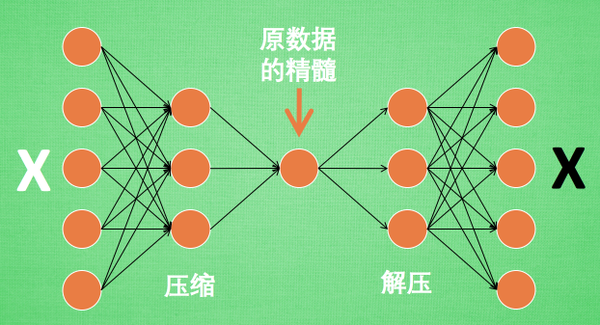

In [10]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
loss_func = nn.MSELoss()

for epoch in range(EPOCH):
    
    for step, (x, b_label) in enumerate(loader):
        
        b_x = x.view(-1, 28*28)   # batch x, shape (batch, 28*28)
        b_y = x.view(-1, 28*28)   # batch y, shape (batch, 28*28)
        #print('Epoch: ', epoch, '| Step: ', step, '| batch x: ',
         #     b_x.numpy(), '| batch y: ', b_y.numpy())

        encoded, decoded = autoencoder(b_x)

        loss = loss_func(decoded, b_y)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()

<IPython.core.display.Javascript object>


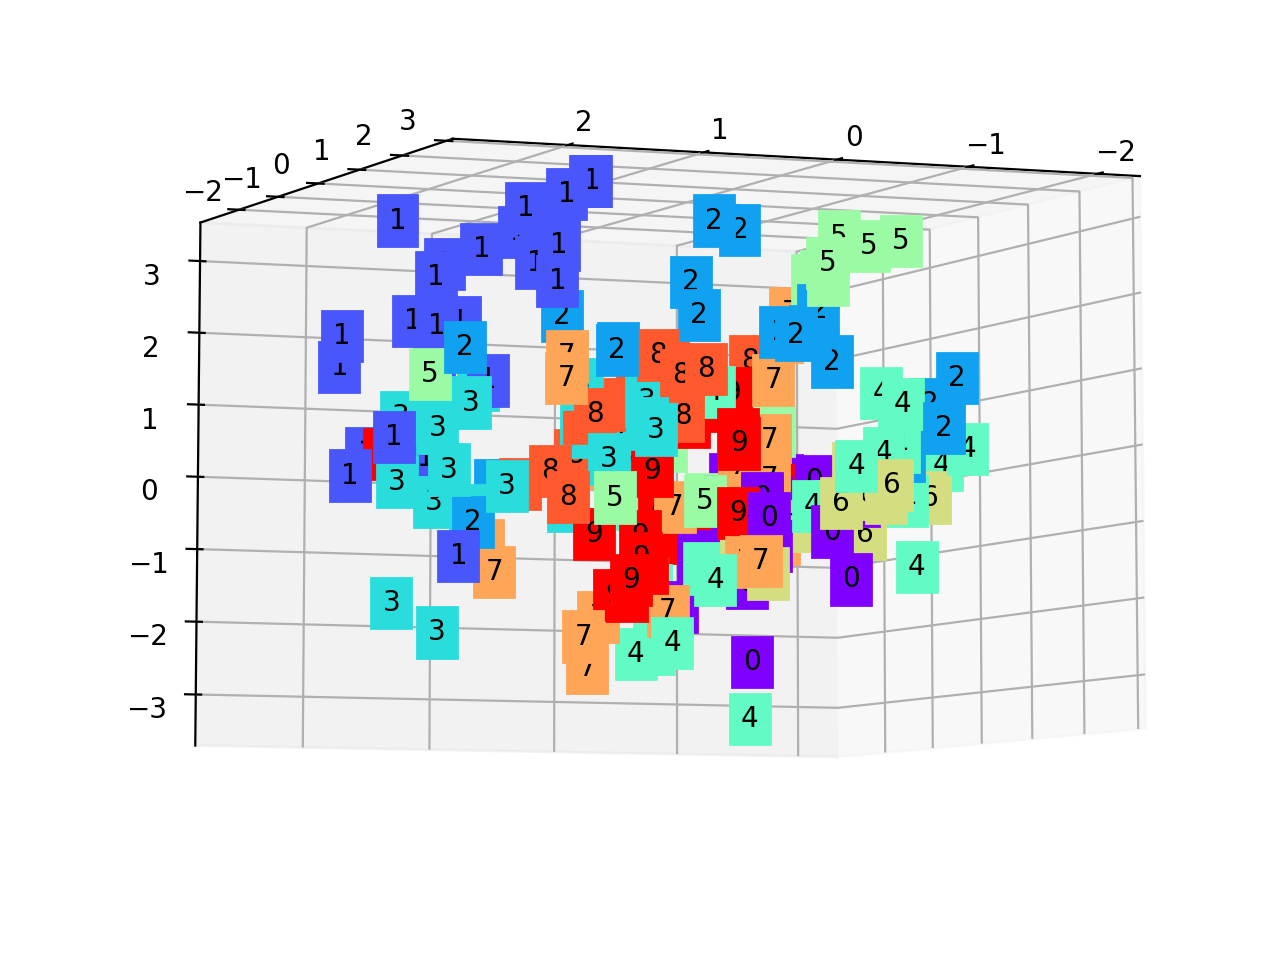

In [18]:
import matplotlib
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as p3d
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
# 要观看的数据
view_data = train_data.train_data[:200].view(-1, 28*28).type(torch.FloatTensor)/255.
encoded_data, _ = autoencoder(view_data)    # 提取压缩的特征值
fig = plt.figure(2)
ax = Axes3D(fig)    # 3D 图
# x, y, z 的数据值
X = encoded_data.data[:, 0].numpy()
Y = encoded_data.data[:, 1].numpy()
Z = encoded_data.data[:, 2].numpy()
values = train_data.train_labels[:200].numpy()  # 标签值
for x, y, z, s in zip(X, Y, Z, values):
    c = matplotlib.cm.rainbow(int(255*s/9))    # 上色
    ax.text(x, y, z, s, backgroundcolor=c)  # 标位子
ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())
plt.show()
#集中-学到了精髓 也是一种同PCA的降维方式